In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap
from pickle import dump, load

from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence, plot_model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Input
from tensorflow.keras.applications import ResNet50V2

from nltk.translate.bleu_score import corpus_bleu

# Load data

In [2]:
dataset = pd.read_csv("input/flickr8k/captions.txt")

In [3]:
dataset.head(5)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [4]:
images = dataset['image'].unique().tolist()
captions = {name_img : dataset.caption[dataset['image'] == name_img].iloc[:].tolist() for name_img in images}

In [5]:
len(images)

8091

In [6]:
for k in ("1000268201_693b08cb0e.jpg", "1001773457_577c3a7d70.jpg"):
    print("Image name: ", k)
    print("Captions: ", captions[k])
    print()

Image name:  1000268201_693b08cb0e.jpg
Captions:  ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']

Image name:  1001773457_577c3a7d70.jpg
Captions:  ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']



# Visualization

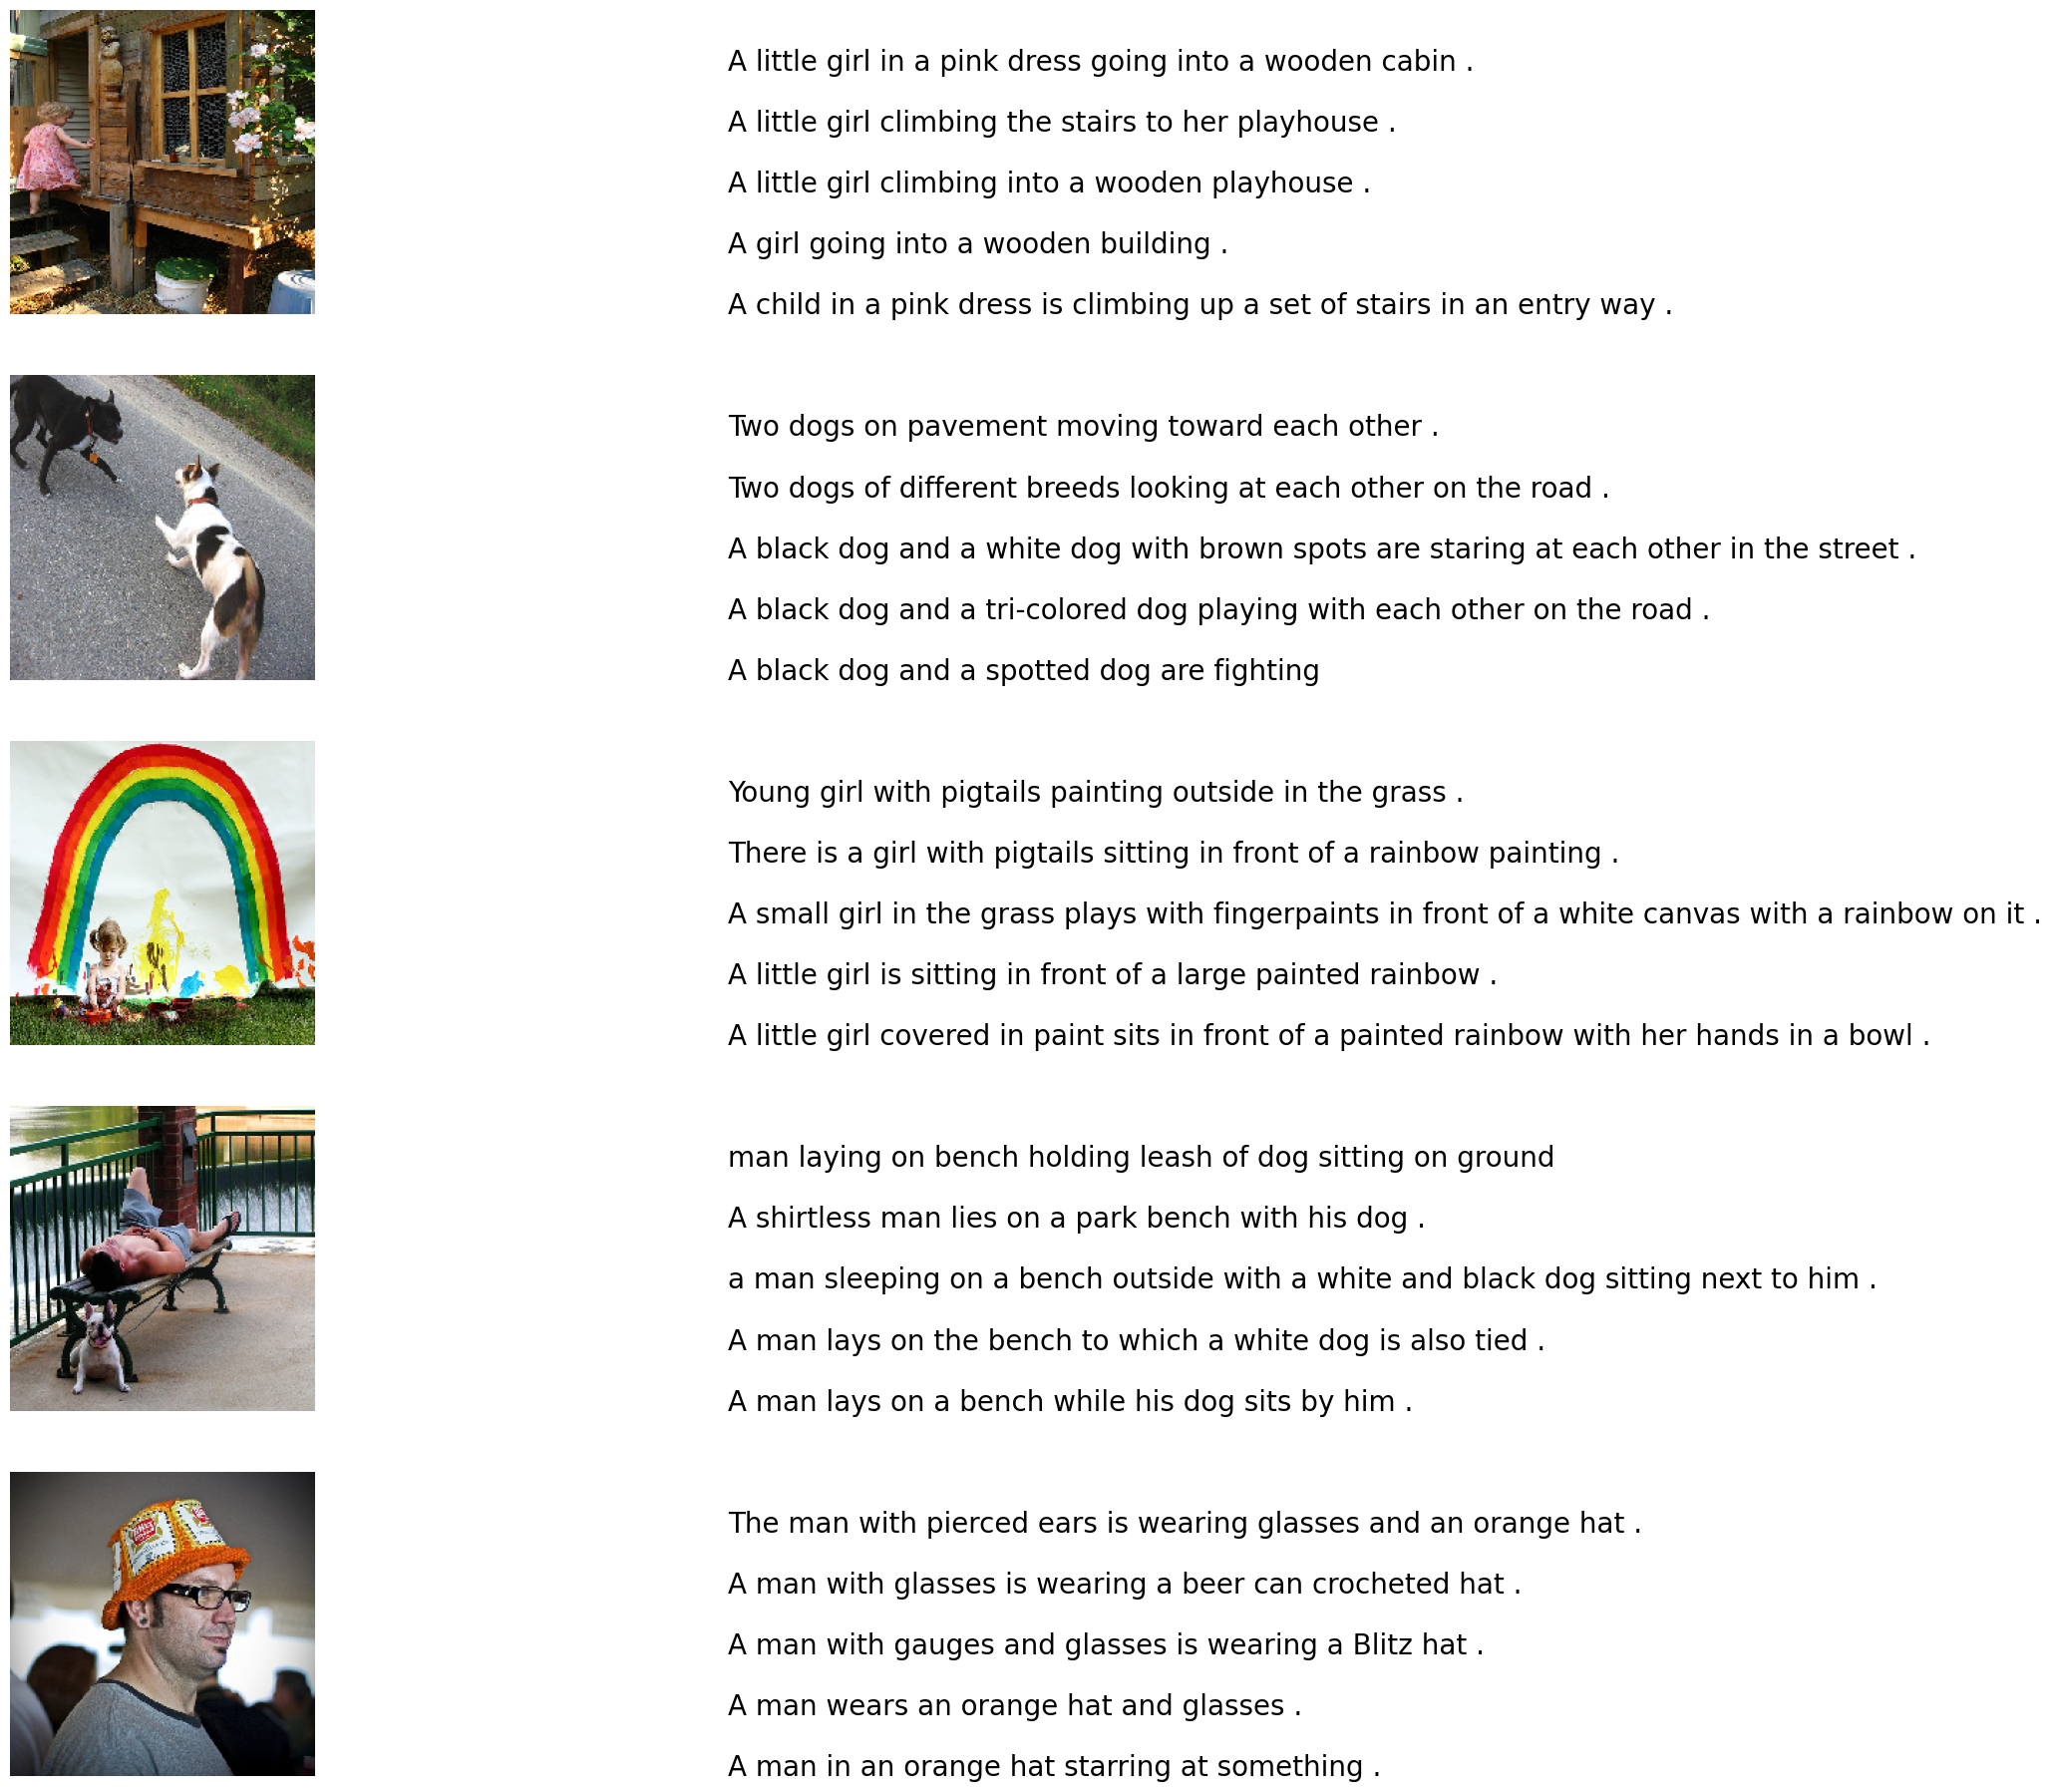

In [7]:
n_pics = 5
fig = plt.figure(figsize=(23, 23))
image_path = r"input/flickr8k/Images/"
position = 1
for i, image_name in enumerate(images[0:5]):
    image = load_img(os.path.join(image_path, image_name), target_size=(214, 214))
    image_caption = captions[image_name]
    ax = fig.add_subplot(n_pics, 2, position)
    ax.imshow(image)
    ax.axis("off")

    position += 1
    ax = fig.add_subplot(n_pics, 2, position)
    plt.axis("off")
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(image_caption))
    for i, caption in enumerate(image_caption):
        ax.text(0,i,caption,fontsize=20)
    position += 1

# Preprocessing data
* Text
* Image

In [8]:
def text_processing(data):
    # Lower word
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    # Remove numeric
    data['caption'] = data['caption'].apply(lambda x: x.replace(r"[^A-Za-z]", ""))
    # Remove single character
    data['caption'] = data['caption'].apply(lambda x: " ".join(word for word in x.split() if len(word) > 1))
    # Add startseq and endseq
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")
    return data

In [9]:
processed_data = text_processing(dataset)

In [10]:
processed_data

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      startseq child in pink dress is climbing up se...  
1        startseq girl going into wooden building endseq  
2      startseq little girl climbing into wooden play...  
3      startseq little girl climbing the stairs to he...  
4      startseq little girl in pink dress going into ...  
...                                                  ...  
40450  startseq man in pink shirt climbs rock face en...  
40451  startseq man is rock climbing high in the air ...  
40452  startseq person in red shirt climbing up rock ...  
40453          startseq rock climber in red shirt endseq  
40454  startseq rock climber practices on rock climbi...  

[40455 rows x 2 columns]

# Feature extraction image

In [ ]:
model = ResNet50V2()
rn50 = Model(inputs=model.input, outputs=model.layers[-2].output)

102869336/102869336 [==============================] - 1s 0us/step


In [28]:
rn50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [29]:
img_size = 224
features = {}
for image in tqdm(dataset['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = rn50.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [11:18<00:00, 11.92it/s]


In [11]:
image_features_file_name = "image_features"

In [33]:
output_file = open(image_features_file_name, "wb")
dump(features, output_file)
output_file.close()

In [12]:
input_file = open(image_features_file_name, "rb")
features = load(input_file)
input_file.close()

In [13]:
features[images[0]].shape

(1, 2048)

# Feature extraction text

In [14]:
token = Tokenizer(lower = False, oov_token="<OOV>")

In [15]:
token.fit_on_texts(dataset['caption'])

In [16]:
MAX_LENGTH = max([len(sent.split()) for sent in dataset['caption']])
VOCAB_SIZE = len(token.word_index) + 1

print(f"Max length: {MAX_LENGTH}")
print(f"Vocab size: {VOCAB_SIZE}")

Max length: 34
Vocab size: 8486


In [17]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [41]:
dim_embedding = 64

input_image = Input(shape=(features[images[0]].shape[1],))
fimage = Dense(256,activation='relu',name="ImageFeature")(input_image)

## sequence model
input_txt = Input(shape=(MAX_LENGTH,))
ftxt = Embedding(VOCAB_SIZE,dim_embedding, mask_zero=True)(input_txt)
ftxt = LSTM(256,name="CaptionFeature")(ftxt)

## combined model for decoder
decoder = add([ftxt,fimage])
decoder = Dense(256,activation='relu')(decoder)
output = Dense(VOCAB_SIZE, activation='softmax')(decoder)


model = Model(inputs=[input_image, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 64)       543104      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 CaptionFeature (LSTM)          (None, 256)          328704      ['embedding[0][0]']              
                                                                                            

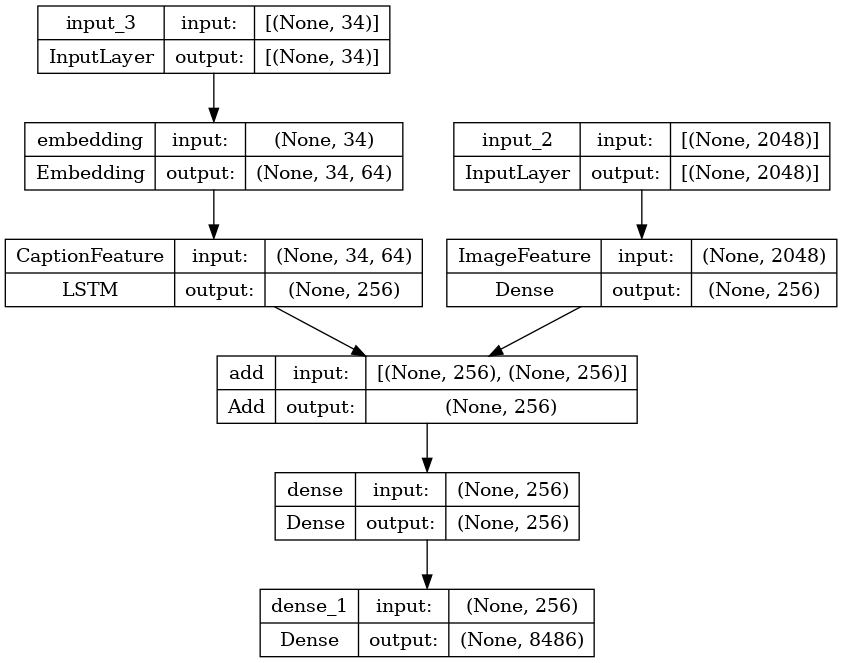

In [43]:
plot_model(model=model, show_shapes=True, show_layer_names=True)

In [18]:
nimages = len(images)
split_index = round(0.7*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = processed_data[processed_data['image'].isin(train_images)]
test = processed_data[processed_data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [19]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64, directory=image_path,
                                      tokenizer=token,vocab_size=VOCAB_SIZE,max_length=MAX_LENGTH,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64, directory=image_path,
                                      tokenizer=token,vocab_size=VOCAB_SIZE,max_length=MAX_LENGTH,features=features)

In [46]:
history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

Epoch 1/10
442/442 [==============================] - 286s 633ms/step - loss: 5.0938 - val_loss: 4.4554
Epoch 2/10
442/442 [==============================] - 103s 233ms/step - loss: 3.9106 - val_loss: 4.0258
Epoch 3/10
442/442 [==============================] - 94s 213ms/step - loss: 3.4100 - val_loss: 3.9456
Epoch 4/10
442/442 [==============================] - 93s 210ms/step - loss: 3.0624 - val_loss: 3.9726
Epoch 5/10
442/442 [==============================] - 92s 208ms/step - loss: 2.7947 - val_loss: 4.0171
Epoch 6/10
442/442 [==============================] - 91s 206ms/step - loss: 2.5866 - val_loss: 4.1019
Epoch 7/10
442/442 [==============================] - 92s 208ms/step - loss: 2.4232 - val_loss: 4.2003
Epoch 8/10
442/442 [==============================] - 91s 206ms/step - loss: 2.2921 - val_loss: 4.2944
Epoch 9/10
442/442 [==============================] - 92s 209ms/step - loss: 2.1810 - val_loss: 4.3633
Epoch 10/10
442/442 [==============================] - 93s 210ms/step -

In [47]:
model.save('model/image_captioning.h5')

In [20]:
model = load_model("model/image_captioning.h5")

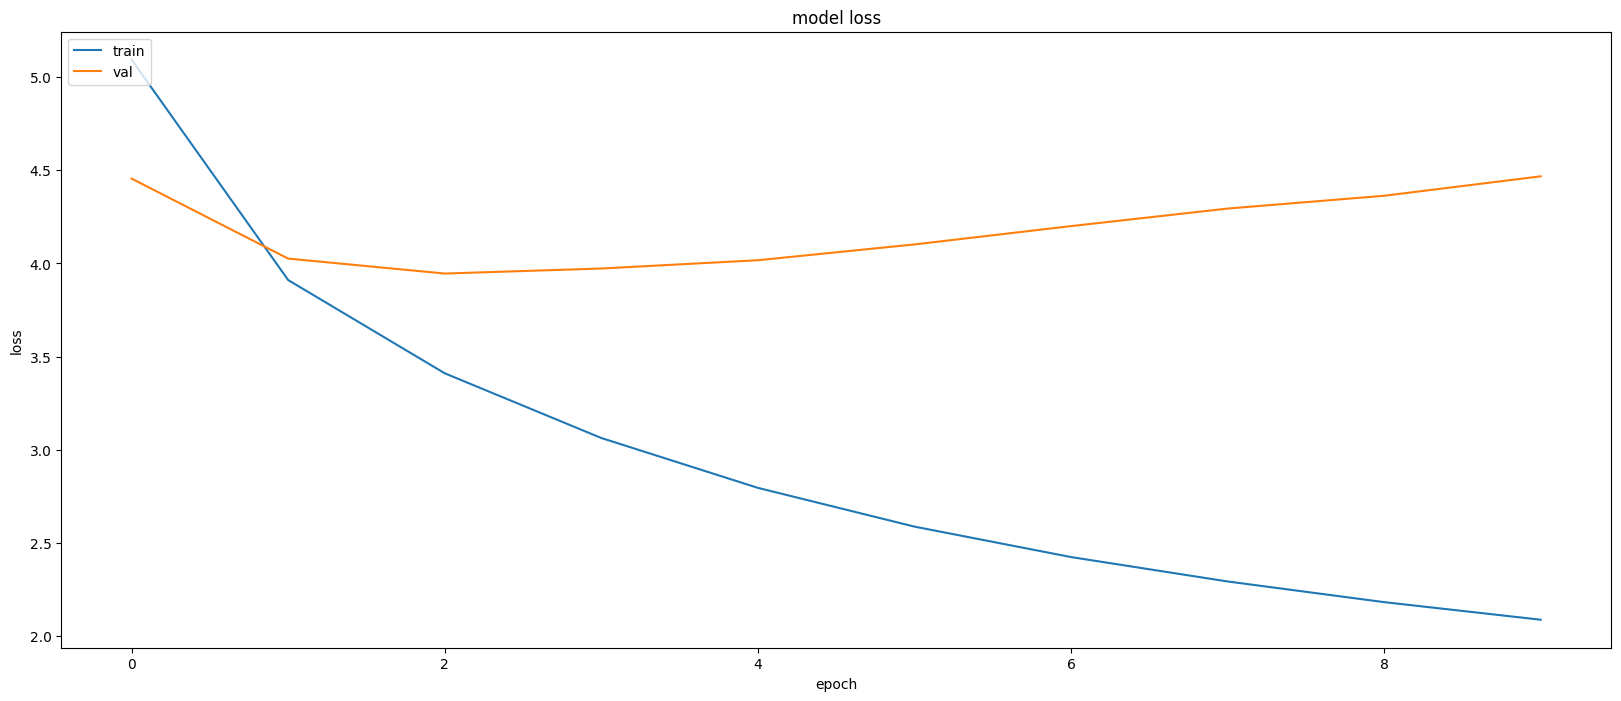

In [48]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [22]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text

In [23]:
test_samples = test.sample(200).copy()
true_samples = test_samples.copy()

In [24]:
for index,record in test_samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(model, record['image'], token, MAX_LENGTH, features)
    test_samples.loc[index,'caption'] = caption

In [25]:
test_samples

image  \
407    3457784061_8f77f43a9c.jpg   
854    3475092236_cf45d383c7.jpg   
4917   3638577494_fe55f7b4cb.jpg   
5212   3649382413_58a4b1efe8.jpg   
11456   836768303_d748df5546.jpg   
...                          ...   
9141    492802403_ba5246cfea.jpg   
2308   3533145793_5d69f72e41.jpg   
1831   3516825206_5750824874.jpg   
6828   3726019124_f302b3d48a.jpg   
1651   3507076266_8b17993fbb.jpg   

                                                 caption  
407    startseq man is jumping off his skateboard whi...  
854    startseq group of people are sitting around th...  
4917        startseq two dogs playing in the sand endseq  
5212   startseq the girl in the blue shirt is sitting...  
11456             startseq woman is hugging woman endseq  
...                                                  ...  
9141    startseq brown dog jumps over green grass endseq  
2308   startseq people are playing in an auditorium e...  
1831   startseq woman is buried in paint and flowery ...  
6828   startseq man is flying over the air over the g...  
1651   startseq woman in red helmet is riding horse e...  

[200 rows x 2 columns]

In [26]:
true_samples

image  \
407    3457784061_8f77f43a9c.jpg   
854    3475092236_cf45d383c7.jpg   
4917   3638577494_fe55f7b4cb.jpg   
5212   3649382413_58a4b1efe8.jpg   
11456   836768303_d748df5546.jpg   
...                          ...   
9141    492802403_ba5246cfea.jpg   
2308   3533145793_5d69f72e41.jpg   
1831   3516825206_5750824874.jpg   
6828   3726019124_f302b3d48a.jpg   
1651   3507076266_8b17993fbb.jpg   

                                                 caption  
407    startseq man is getting ready to throw bowling...  
854    startseq crow of people taking pictures and cl...  
4917   startseq tan dog watching brown dog swimming i...  
5212   startseq woman sits with wearing union jack no...  
11456  startseq two children and brown dog in brown t...  
...                                                  ...  
9141   startseq two dogs are playing in fenced in yar...  
2308   startseq children learn the art of yoga on col...  
1831   startseq woman and barefoot man lay down on ro...  
6828   startseq kites attached to wheeled devices in ...  
1651       startseq man walking large black horse endseq  

[200 rows x 2 columns]

In [27]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(f"input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

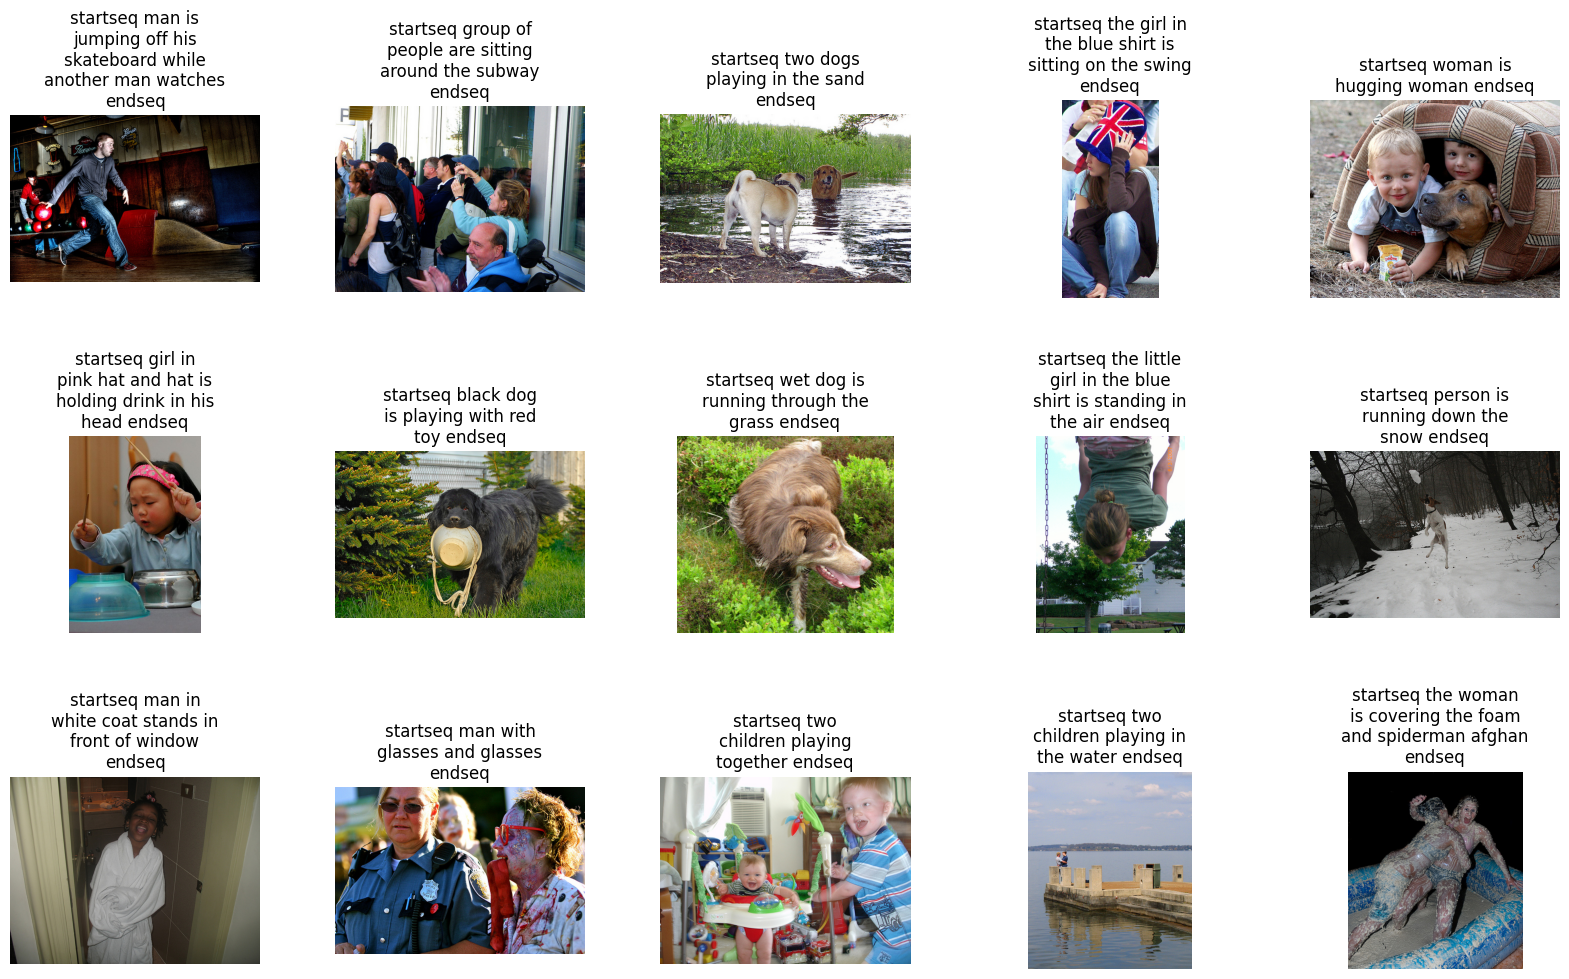

In [28]:
display_images(test_samples.iloc[:15])

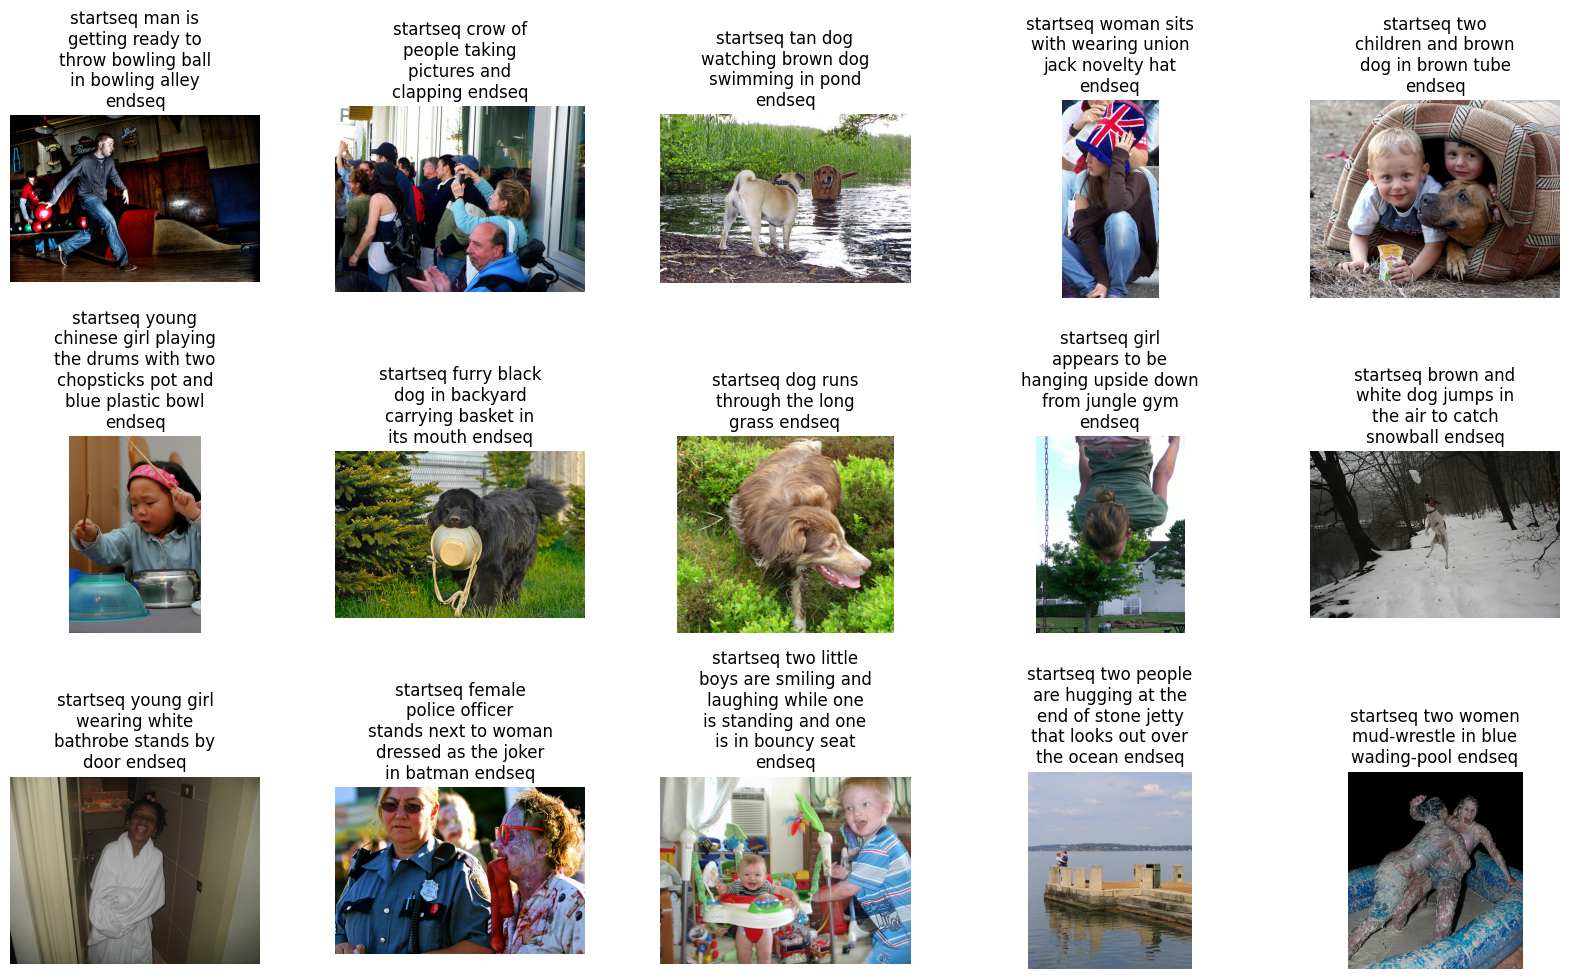

In [29]:
display_images(true_samples.iloc[:15])

In [30]:
def bleu_score(predicted_samples, actual_samples):
    actual, predicted = [], []
    for i, predicted_samples in enumerate(predicted_samples):
        try:
          raw_target = actual_samples.iloc[i][9:].lower()
          actual.append([raw_target.split()])
          predicted.append(predicted_samples.split())
        except:
          pass
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

In [31]:
# Compute the BLEU Score
bleu_test = bleu_score(test_samples["caption"], true_samples["caption"])

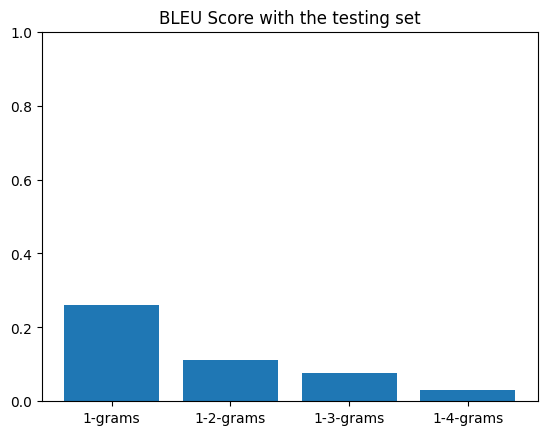

In [32]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the testing set")
plt.ylim((0,1))
plt.show()